# Analysis of the heart CTO Data

In this notebook, we carry out the analysis of Heart CTO data. We want to predict the survival of a patience, given a set of covariates.
One thing we notice is that the data cannot considered to be i.i.d., as they are sampled from a number of different hospitals.

The solution to the problem is two-folds: first, we cross-validate by sampling from groups and, at the same time we keep a balance between the two classes. Another thing we do is to split between train and test considering two different groups.

## Modules
We import the modules

In [70]:
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedGroupKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
import seaborn as sns
import numpy as np
from sklearn.metrics import auc, balanced_accuracy_score, roc_auc_score, make_scorer, RocCurveDisplay
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
import lightgbm as lgb
from flaml import AutoML
from flaml.automl.data import get_output_from_log
import pickle
sns.set_style("whitegrid")
import mlflow
from pathlib import Path

## Reading the file
We import that Excel data file

In [71]:
# Read the file
df = pd.read_excel(
    io = "data/raw/dataset4analysis_Masca bis.xlsx",
    sheet_name = "Foglio1",
    header = 0,
    usecols = "B,C,E:AQ,AU,AR:AT",
    verbose = True)

Reading sheet Foglio1


In [72]:
df.head()

,Center,Center_Volume,Sex,Age,WEIGHT,LENGTH,BMI,CURRENT_SMOKER,HYPERTENSION,HYPERCHOLESTEROLEMIA,...,GUIDEWIRE_TAR_ANGIO_APP,SIDE_BRANCH,AMBIG_PROX_CAP,LACK_INTERV_COLL,BAD_DLZ,DIST_CAP_BIFU,JCTO_SUM,PROGRESS,RECHARGE_score,Procedure_success
0,Genk,1.0,0.0,77.0,70.0,169.0,24.508946,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,3,1.0,5.0,1
1,Genk,1.0,0.0,71.0,104.0,170.0,35.986159,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0,1
2,Genk,1.0,0.0,69.0,70.0,170.0,24.221453,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,1.0,1
3,Genk,1.0,0.0,72.0,69.0,165.0,25.344353,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,3,1.0,5.0,1
4,Genk,1.0,0.0,68.0,80.0,182.0,24.151673,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,2,0.0,3.0,1


In [73]:
# Fix columns names
df.columns = df.columns.str.lower().str.replace(' ','')

In [74]:
df.columns

Index(['center', 'center_volume', 'sex', 'age', 'weight', 'length', 'bmi',
       'current_smoker', 'hypertension', 'hypercholesterolemia', 'diabetes',
       'acute_cor_synd_hist', 'myocard_inf_hist', 'cabg_hist',
       'coron_hist_pci', 'periph_vasc_disease_hist',
       'chron_kidney_disease_hist', 'lvef_normal_only', 'acute_cor_synd',
       'multivess', 'target_vess_for_cto', 'target_vessel_cto_explained',
       'cto_lcx', 'ost_cto_lesion', 'prev_pci_of_target_cto',
       'cto_in_prev_impl_stent', 'prev_cabg_on_target_vess', 'rentrop',
       'stenosis_50_perc', 'clear_stump', 'blunt_stump', 'calcific',
       'bending_gt_45_deg', 'cto_length', 're_try', 'guidewire_tar_angio_app',
       'side_branch', 'ambig_prox_cap', 'lack_interv_coll', 'bad_dlz',
       'dist_cap_bifu', 'jcto_sum', 'progress', 'recharge_score',
       'procedure_success'],
      dtype='object')

In [75]:
df = df.drop("target_vessel_cto_explained",axis=1)

In [76]:
df = df.dropna(subset=['jcto_sum', 'progress', 'recharge_score'])

In [77]:
print(df['current_smoker'].unique())
df.loc[df['current_smoker'] < 0.] = pd.NA
df['current_smoker'].unique()

[  0.   1.  nan -98. -96. -99.]


array([ 0.,  1., nan])

In [78]:
print(df['hypertension'].unique())
df.loc[df['hypertension'] < 0.] = pd.NA
print(df['hypertension'].unique())

[  1.   0.  nan -98.]
[ 1.  0. nan]


In [79]:
print(df['hypercholesterolemia'].unique())
df.loc[df['hypercholesterolemia'] < 0.] = pd.NA
print(df['hypercholesterolemia'].unique())

[  1.   0.  nan -99.]
[ 1.  0. nan]


In [80]:
print(df['diabetes'].unique())

[ 0.  1. nan]


In [81]:
print(df['acute_cor_synd_hist'].unique())

[ 0.  1. nan]


In [82]:
print(df['myocard_inf_hist'].unique())

[ 0.  1. nan]


In [83]:
print(df['cabg_hist'].unique())

[ 1.  0. nan]


In [84]:
print(df['coron_hist_pci'].unique())

[ 0.  1. nan]


In [85]:
print(df['periph_vasc_disease_hist'].unique())
df.loc[df['periph_vasc_disease_hist'] < 0.] = pd.NA
print(df['periph_vasc_disease_hist'].unique())

[  0.   1.  nan -99.]
[ 0.  1. nan]


In [86]:
print(df['chron_kidney_disease_hist'].unique())

[ 0.  1. nan]


In [87]:
print(df['lvef_normal_only'].unique())
df.loc[df['lvef_normal_only'] == 6.] = pd.NA
print(df['lvef_normal_only'].unique())

[ 1.  0. nan  6.]
[ 1.  0. nan]


In [88]:
print(df['acute_cor_synd'].unique())
df.loc[df['acute_cor_synd'] == 2.] = pd.NA
print(df['acute_cor_synd'].unique())

[ 0.  1. nan  2.]
[ 0.  1. nan]


In [89]:
print(df['multivess'].unique())
df['multivess'].value_counts()
df.loc[df['multivess'] == 2.] = 1.
df.loc[df['multivess'] == 3.] = 1.
print(df['multivess'].value_counts())

[ 1.  0.  2.  3. nan]
multivess
1.0    3684
0.0    3375
Name: count, dtype: int64


In [90]:
print(df['target_vess_for_cto'].unique())
df['target_vess_for_cto'].value_counts()

[ 1.  2.  3.  4.  0. nan]


target_vess_for_cto
1.0    4161
2.0    1811
3.0    1085
4.0      26
0.0      13
Name: count, dtype: int64

In [91]:
print(df['cto_lcx'].unique())

[ 0.  1. nan]


In [92]:
print(df['ost_cto_lesion'].unique())

[nan  0.  1.]


In [93]:
print(df['prev_pci_of_target_cto'].unique())

[ 0.  1. nan]


In [94]:
print(df['cto_in_prev_impl_stent'].unique())

[ 0.  1. nan]


In [95]:
print(df['prev_cabg_on_target_vess'].unique())

[ 1.  0. nan]


In [96]:
print(df['rentrop'].unique())
df.loc[df['rentrop'] == -96.] = pd.NA
print(df['rentrop'].unique())

[  3.   2.   1.   0.  nan -96.]
[ 3.  2.  1.  0. nan]


In [97]:
print(df['stenosis_50_perc'].unique())

[ 1.  0. nan]


In [98]:
print(df['clear_stump'].unique())

[ 1.  0. nan]


In [99]:
print(df['blunt_stump'].unique())

[ 1.  0. nan]


In [100]:
print(df['calcific'].unique())

[ 1.  0. nan]


In [101]:
print(df['bending_gt_45_deg'].unique())

[ 0.  1. nan]


In [102]:
print(df['cto_length'].unique())
df.loc[df['cto_length'] == -1.] = pd.NA
print(df['cto_length'].unique())

[ 1.  0. nan -1.]
[ 1.  0. nan]


In [103]:
print(df['re_try'].unique())

[ 0.  1. nan  2.  4. 12.  3.]


In [104]:
print(df['guidewire_tar_angio_app'].unique())

[ 1.  0. nan]


In [105]:
print(df['side_branch'].unique())

[ 1.  0. nan]


In [106]:
print(df['ambig_prox_cap'].unique())

[ 1.  0. nan]


In [107]:
print(df['lack_interv_coll'].unique())
df.loc[df['lack_interv_coll'].isin([-96., -98.])] = pd.NA
print(df['lack_interv_coll'].unique())

[  0.   1.  nan -96. -98.]
[ 0.  1. nan]


In [108]:
print(df['bad_dlz'].unique())

[ 1.  0. nan]


In [109]:
df['dist_cap_bifu'].value_counts()

dist_cap_bifu
0.0    3285
1.0    1580
Name: count, dtype: int64

In [110]:
df['procedure_success'].value_counts()

procedure_success
1.0    6214
0.0     877
Name: count, dtype: int64

In [111]:
df.loc[df["age"] <= 10.] = pd.NA

In [112]:
df.loc[df["weight"] >= 80000.] = pd.NA
df.loc[df["weight"] < 0.] = pd.NA

In [113]:
df.loc[df["length"] < 0.] = pd.NA

In [114]:
group_labels = df.center

In [115]:
inverted_centers = []

In [116]:
for label in set(group_labels):
    female = df[(df["center"] == label) & (df["sex"] == 1.0)].shape
    male = df[(df["center"] == label) & (df["sex"] == 0.0)].shape
    if (male < female):
        inverted_centers.append(label)
        df.loc[(df["center"] == label), "sex"] = df.loc[(df["center"] == label), "sex"].map(lambda x: 1. - x)

In [117]:
for label in set(inverted_centers):
    female = df[(df["center"] == label) & (df["sex"] == 1.0)].shape
    male = df[(df["center"] == label) & (df["sex"] == 0.0)].shape
    assert male >= female, "Males should be greater or equal than females..."

In [118]:
df = df.drop("center", axis=1)

## Split train and test

In [119]:
X = df.drop("procedure_success", axis=1)
y = df["procedure_success"]

In [120]:
X.shape

(7135, 42)

In [121]:
X = X[y.isna() == False]
group_labels = group_labels[y.isna() == False]

In [122]:
y = y[y.isna() == False]

In [123]:
group_labels

0                             Genk
1                             Genk
2                             Genk
3                             Genk
4                             Genk
                   ...            
8897    Health Sciences University
8898    Health Sciences University
8900    Health Sciences University
8902      University Hospital Brno
8903      University Hospital Brno
Name: center, Length: 6918, dtype: object

In [124]:
X.shape

(6918, 42)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20240110, stratify=y)

In [126]:
X_train.shape[0] / (X_train.shape[0] + X_test.shape[0])

0.7499277247759468

In [127]:
X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])

0.2500722752240532

## Tuning of the hyperparams

In [128]:
settings = {
    "time_budget": 10800,  # total running time in seconds
    "metric": 'roc_auc',
    "estimator_list": ["lgbm"],
    "task": 'classification',  # task type
    "log_file_name": 'heart_cto.log',  # flaml log file
    "seed": 20240110,    # random seed
}

In [129]:
automl = AutoML()

In [130]:
# Save the model
output_path = Path("automl-20240815.pkl")

In [131]:
%%capture
if output_path.is_file() == False:
    print(f"No file at {output_path}")
    automl.fit(X_train=X_train, y_train=y_train, **settings)
    with open(output_path, "wb") as f:
        pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
else:
    print(f"File found at {output_path}...")
    with open(output_path, "rb") as f:
        automl = pickle.load(f)

In [139]:
print(automl.model)

In [140]:
print(automl.best_estimator)
print(automl.best_config)

lgbm
{'n_estimators': 54, 'num_leaves': 7, 'min_child_samples': 3, 'learning_rate': 0.10983304546963532, 'log_max_bin': 5, 'colsample_bytree': 0.6603318938735175, 'reg_alpha': 0.001189799520070315, 'reg_lambda': 0.32221818438658506}


In [141]:
pred = automl.predict_proba(X_test)

In [142]:
roc_auc_score(y_test, pred[:, 1])

0.7332793211521652

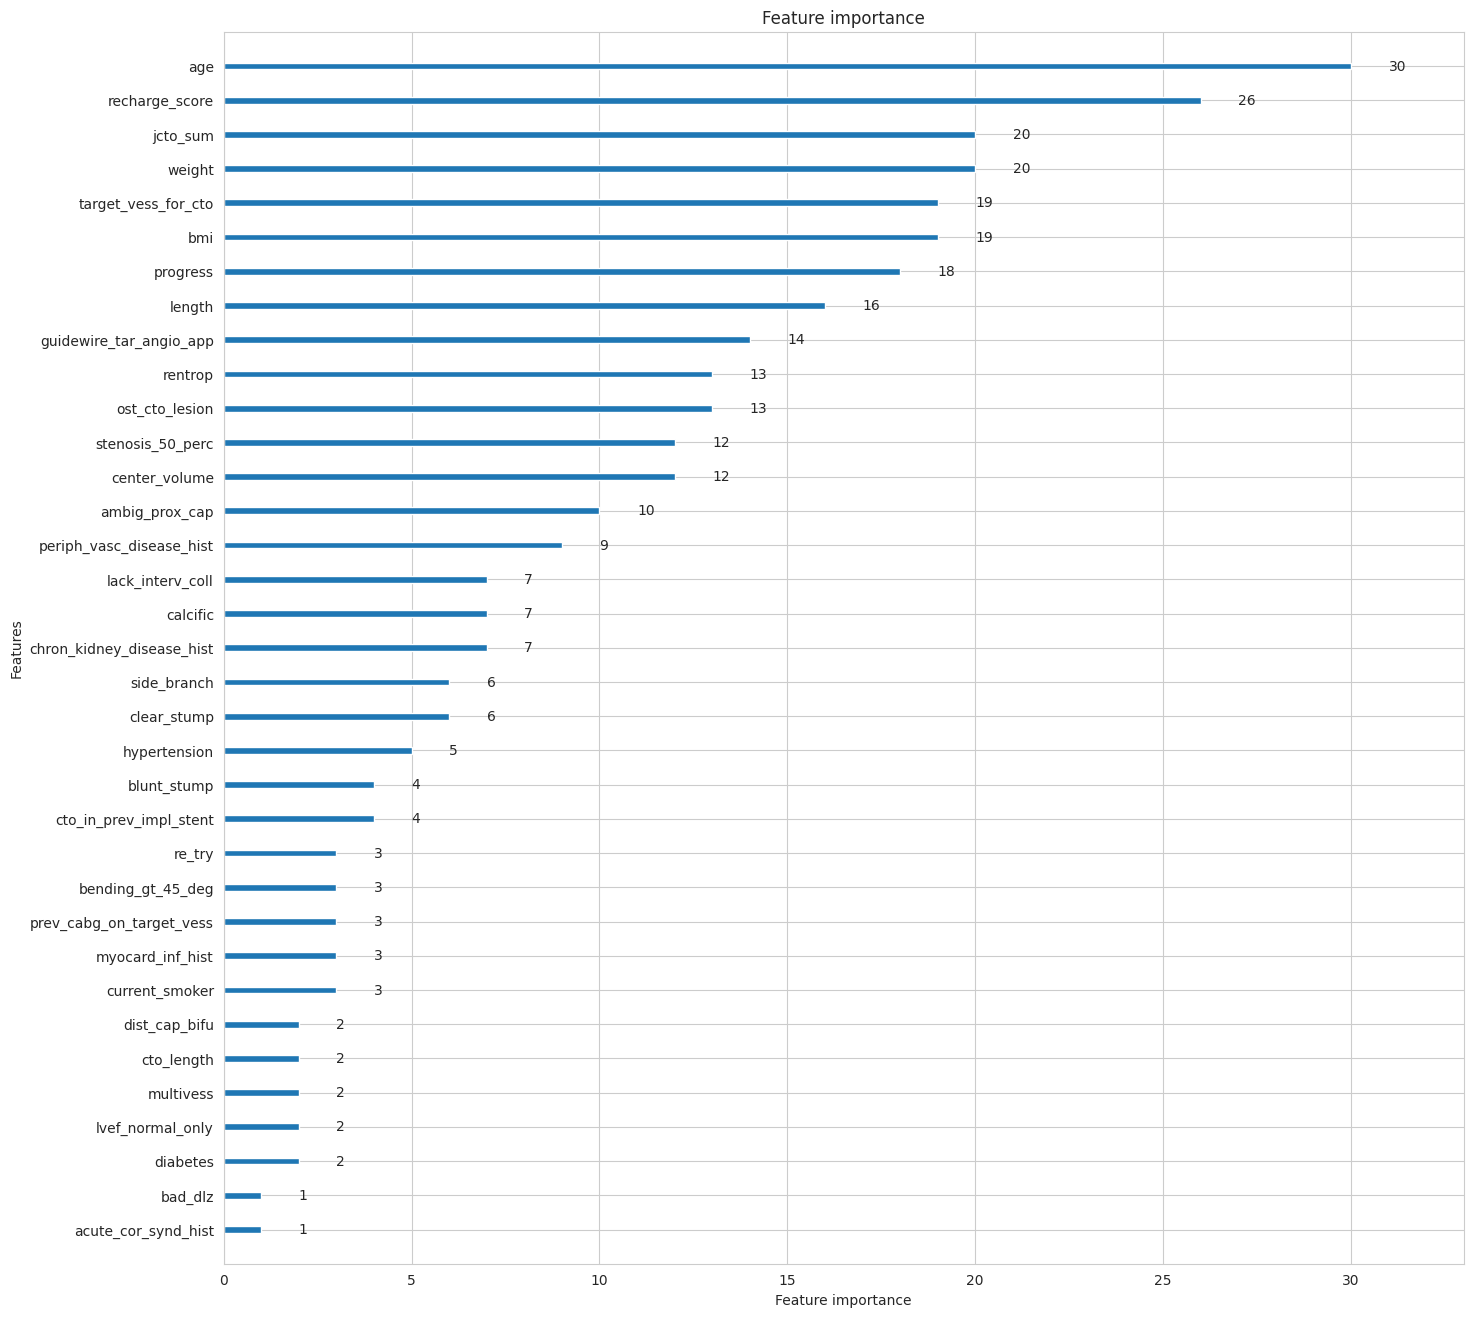

In [143]:
plt.rcParams["figure.figsize"] = (16, 16)
lgb.plot_importance(automl.model.estimator)
plt.savefig('reports/figures/lightgbm_feature_importance.png', dpi=900)

In [144]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename="heart_cto.log", time_budget=18000)

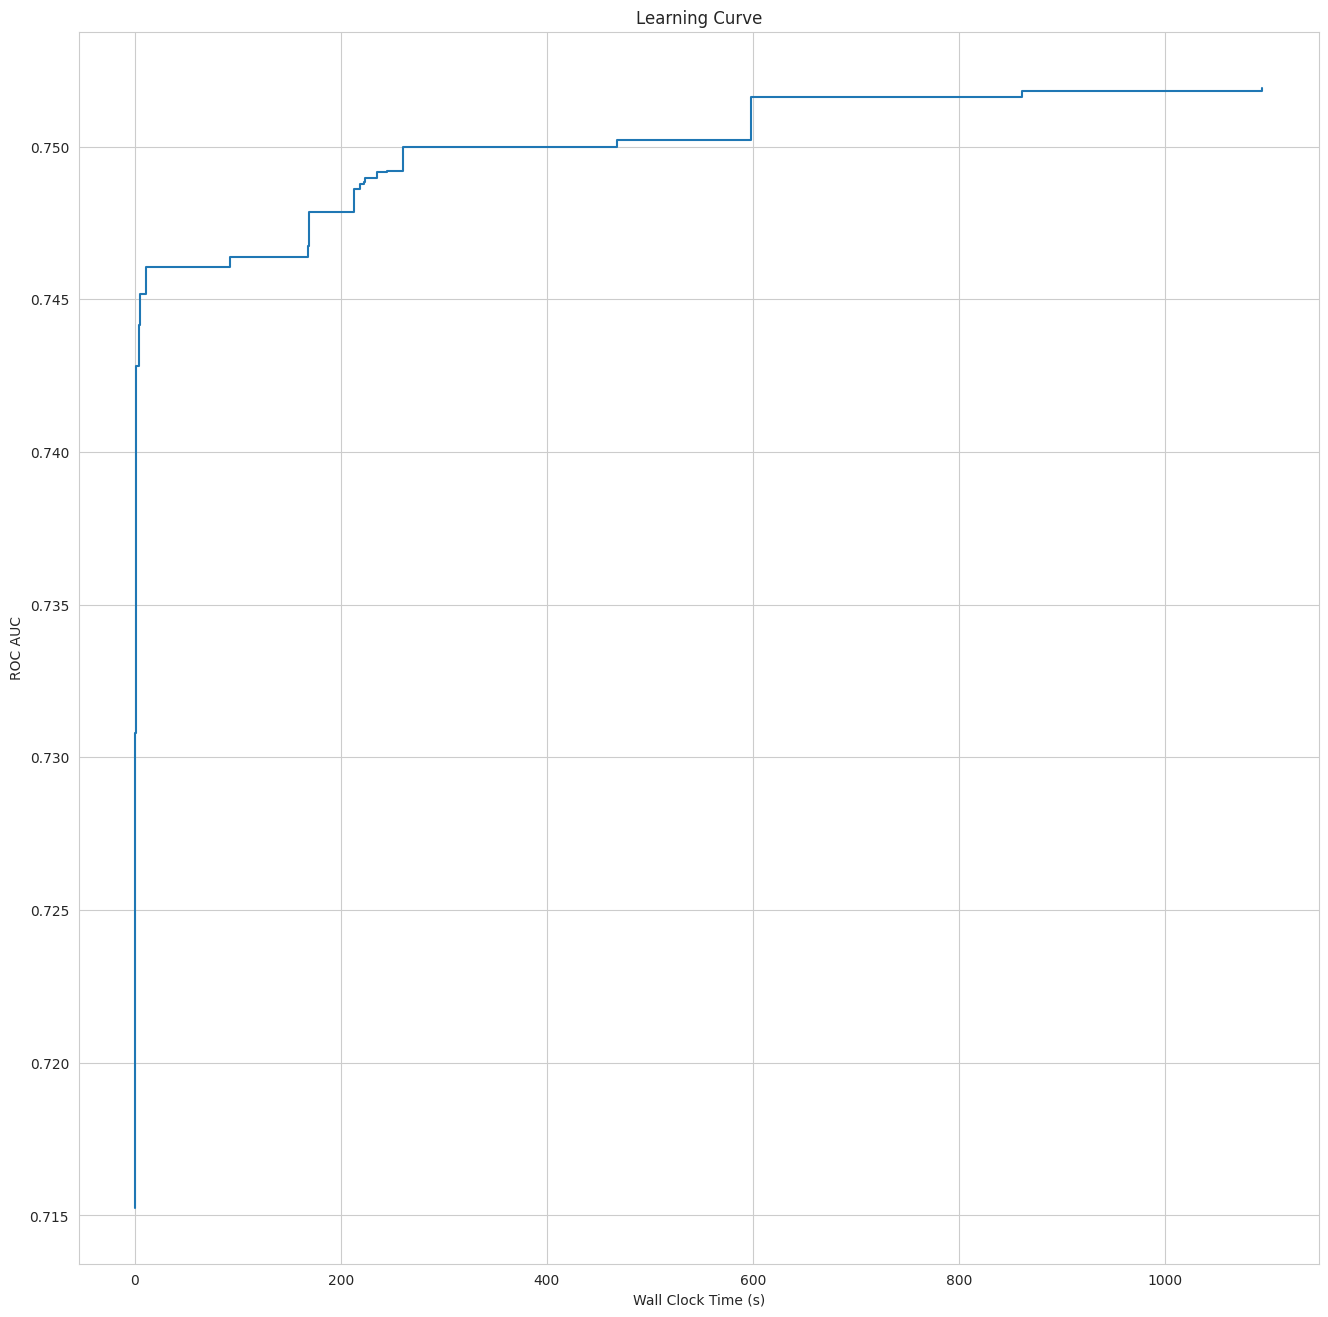

In [145]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("ROC AUC")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()

# Some Plots


In [146]:
y_pred_proba_train = automl.predict_proba(X_train)
y_pred_proba_test = automl.predict_proba(X_test)

fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
auc_train = sklearn.metrics.auc(fpr_train, tpr_train)

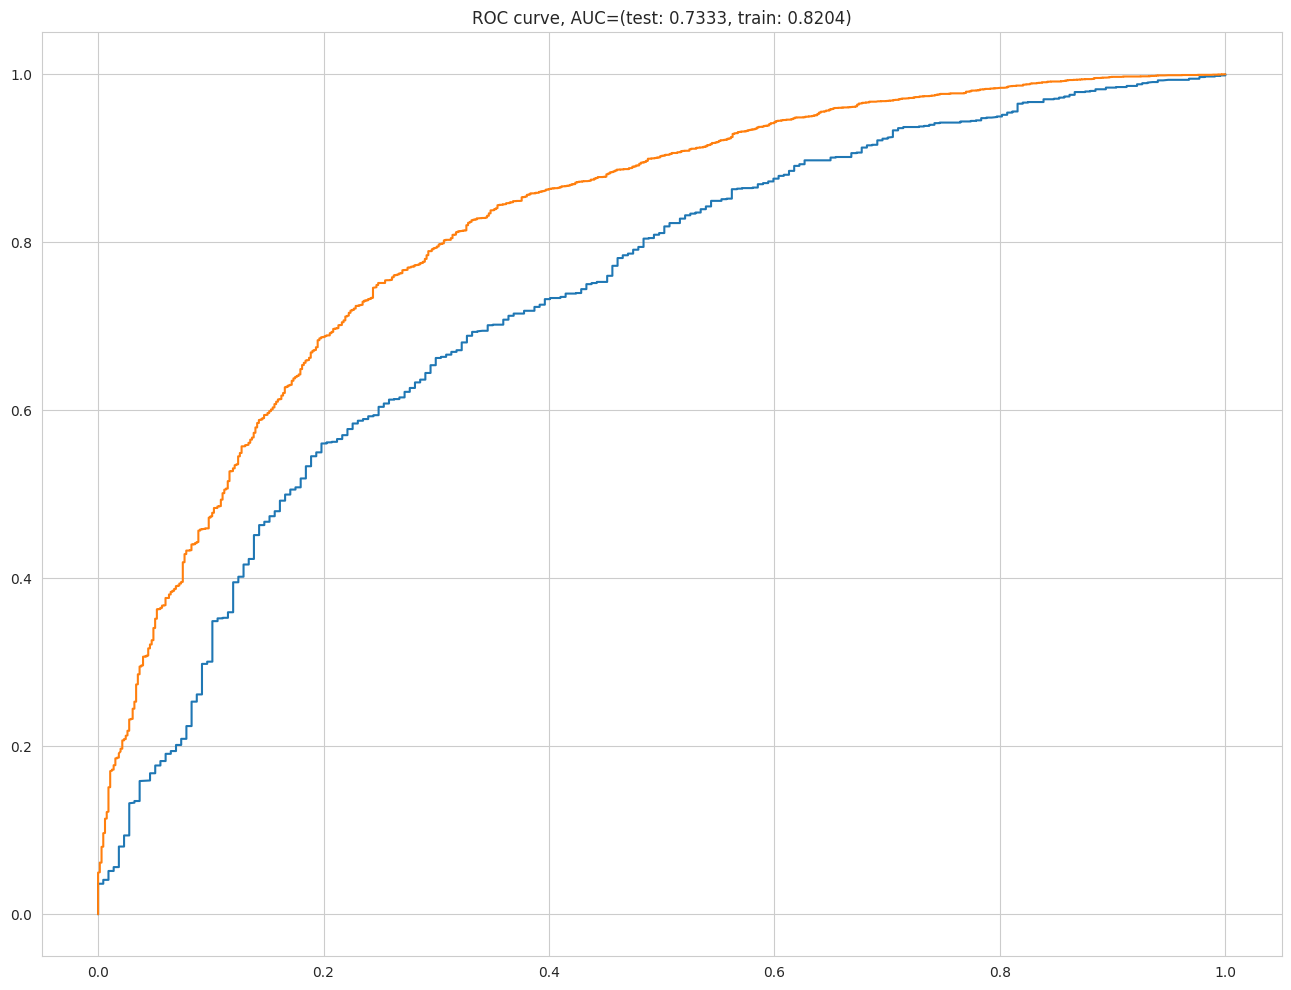

In [147]:
plt.figure(figsize=(16,12))
plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.savefig('reports/figures/lightgbm_roc_auc_train_test.png', dpi=900)

In [148]:
df_train = df.loc[X_train.index]
df_test = df.loc[X_test.index]

In [149]:
# Save training and test sets for later use
df_train.to_excel("data/processed/training.xlsx")
df_test.to_excel("data/processed/testing.xlsx")

In [150]:
# Export for R usage with Stan
df.to_parquet("data/processed/data.parquet")

In [151]:
# Save test sets for scores
scores = pd.read_excel(
    io = "data/raw/dataset4analysis_Masca bis.xlsx",
    sheet_name = "Foglio1",
    header = 0,
    usecols = "AR:AU",
    verbose = True)

Reading sheet Foglio1


In [152]:
scores_test = scores.loc[X_test.index]

In [153]:
scores_test

,JCTO_SUM,PROGRESS,RECHARGE_score,Procedure_success
2269,3,1.0,3.0,1
6190,3,1.0,4.0,1
1274,3,3.0,2.0,1
6956,1,3.0,1.0,1
3562,2,0.0,2.0,1
...,...,...,...,...
1047,2,1.0,2.0,1
93,2,3.0,3.0,0
5078,1,1.0,1.0,1
2097,3,2.0,3.0,1


In [154]:
scores_test.to_excel("data/processed/scores_test.xlsx")

In [155]:
scores_test = scores_test.dropna()

In [156]:
scores_training = scores.loc[X_train.index]
scores_training.to_excel("data/processed/scores_training.xlsx")

In [157]:
# Save test sets for scores
full = pd.read_excel(
    io = "data/raw/dataset4analysis_Masca bis.xlsx",
    sheet_name = "Foglio1",
    header = 0,
    verbose = True)

Reading sheet Foglio1


In [158]:
full_training = full.loc[X_train.index]
full_training.to_excel("data/processed/full_training.xlsx")

In [159]:
full_testing = full.loc[X_test.index]
full_testing.to_excel("data/processed/full_test.xlsx")

In [ ]:
y_pred_jcto_sum = 1. - scores_test.JCTO_SUM / 5.
y_pred_progress = 1. - scores_test.PROGRESS / 4.
y_pred_recharge = 1. - scores_test.RECHARGE_score / 6.

In [175]:
np.save(file="data/processed/y_test", arr=y_test)
np.save(file="data/processed/y_pred_jcto_sum", arr=y_pred_jcto_sum)
np.save(file="data/processed/y_pred_progress", arr=y_pred_progress)
np.save(file="data/processed/y_pred_recharge", arr=y_pred_recharge)
np.save(file="data/processed/y_pred_lightgbm", arr=y_pred_proba_test[:,1])

In [161]:
fpr_jcto, tpr_jcto, _ = sklearn.metrics.roc_curve(y_test, y_pred_jcto_sum)
fpr_progress, tpr_progress, _ = sklearn.metrics.roc_curve(y_test, y_pred_progress)
fpr_recharge, tpr_recharge, _ = sklearn.metrics.roc_curve(y_test, y_pred_recharge)

auc_jcto = sklearn.metrics.auc(fpr_jcto, tpr_jcto)
auc_progress = sklearn.metrics.auc(fpr_progress, tpr_progress)
auc_recharge = sklearn.metrics.auc(fpr_recharge, tpr_recharge)

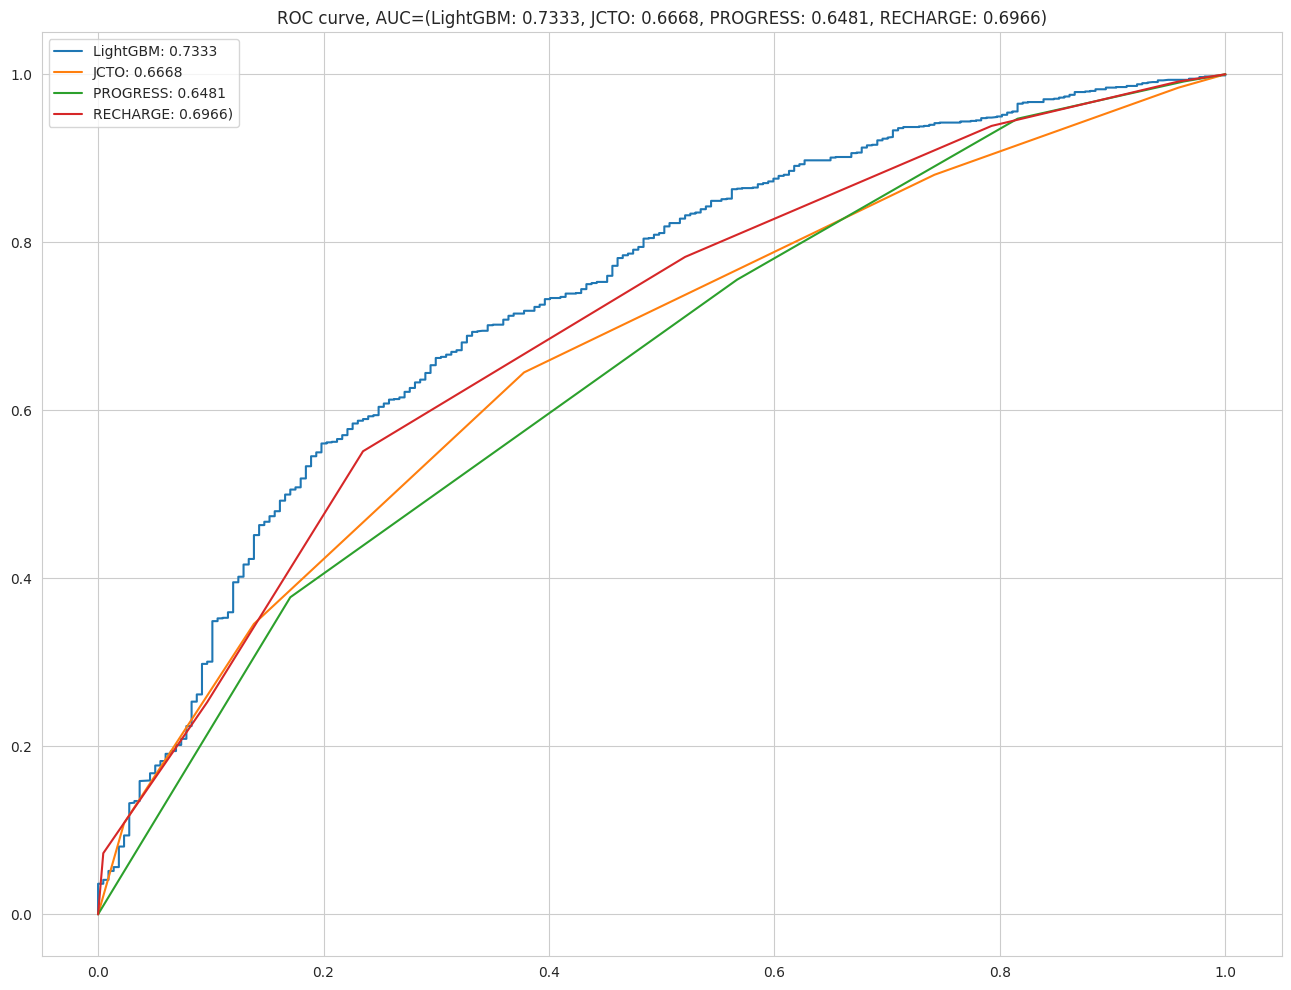

In [162]:
plt.figure(figsize=(16,12))
plt.title(f"ROC curve, AUC=(LightGBM: {auc_test:.4f}, JCTO: {auc_jcto:.4f}, PROGRESS: {auc_progress:.4f}, RECHARGE: {auc_recharge:.4f})")
plt.plot(fpr_test, tpr_test, label="LightGBM")
plt.plot(fpr_jcto, tpr_jcto, label="JCTO")
plt.plot(fpr_progress, tpr_progress, label="PROGRESS")
plt.plot(fpr_recharge, tpr_recharge, label="RECHARGE")
plt.legend([f"LightGBM: {auc_test:.4f}", f"JCTO: {auc_jcto:.4f}", f"PROGRESS: {auc_progress:.4f}", f"RECHARGE: {auc_recharge:.4f})"])
plt.savefig('reports/figures/score_comparison.pdf', dpi=900)

In [163]:
X['sex'].value_counts()
(2321 / 4444) * 100

52.22772277227723

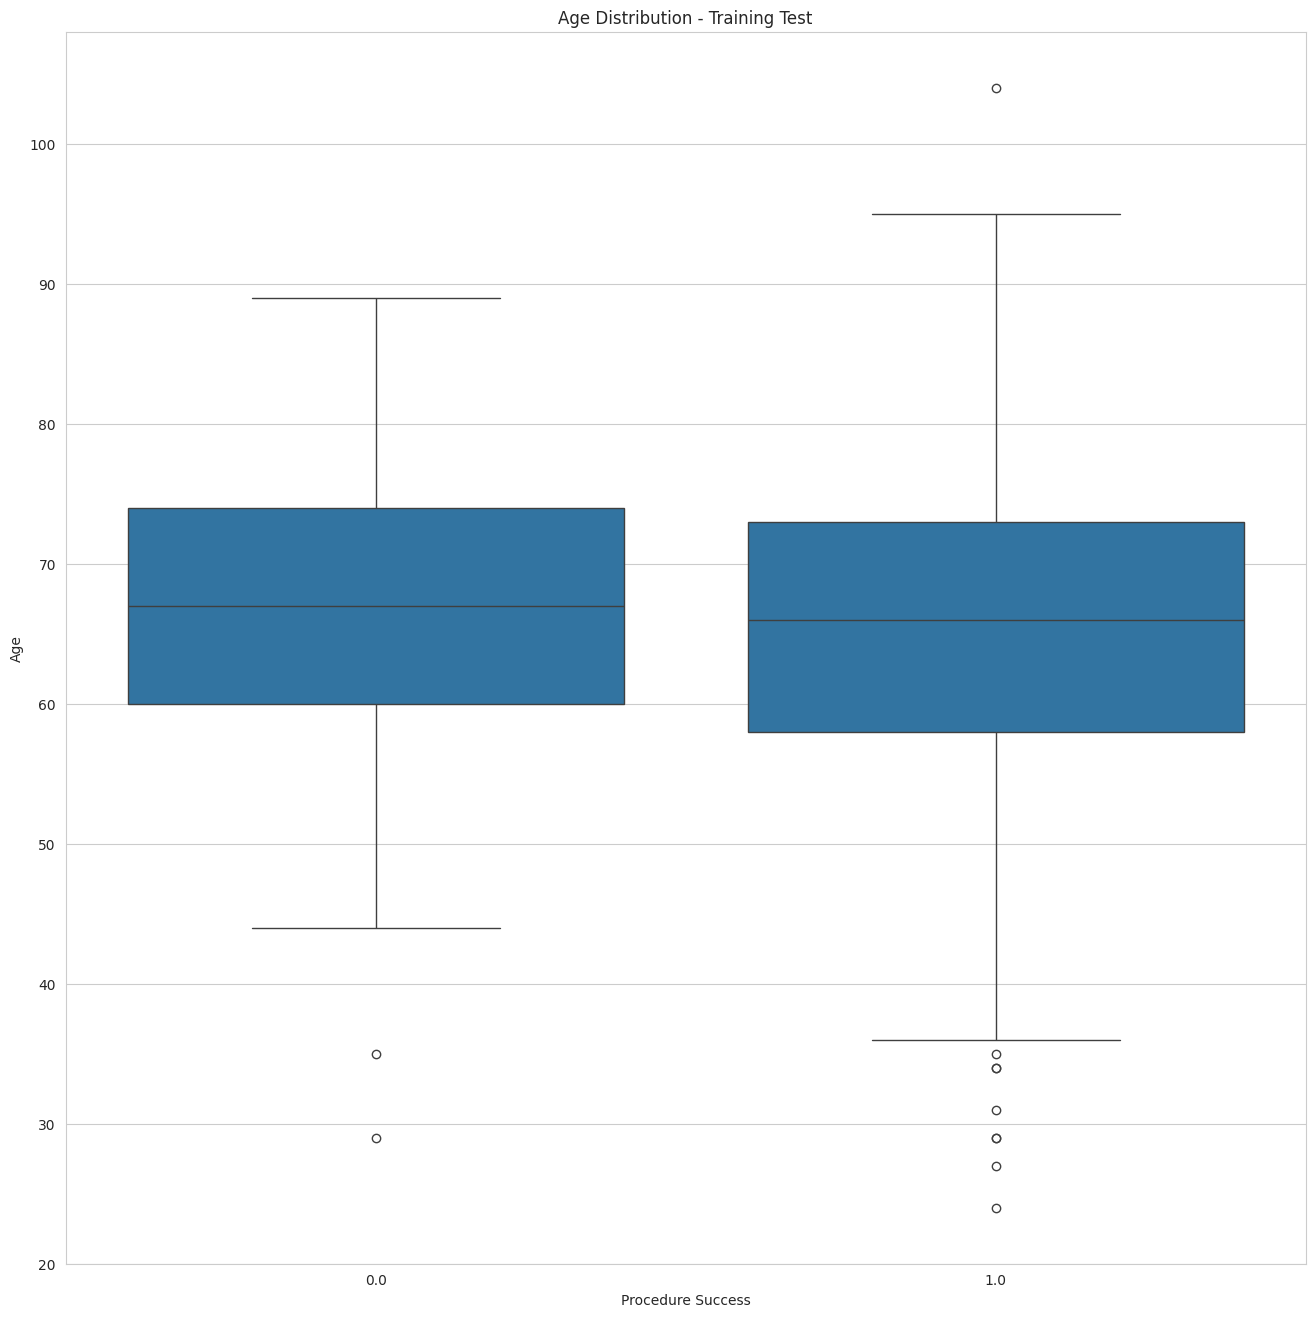

In [164]:
# Plot the age
sns.boxplot(x="procedure_success", y="age", data=df_train).set(title = "Age Distribution - Training Test", xlabel = "Procedure Success", ylabel = "Age")
plt.savefig('reports/figures/age_distribution_train.pdf', dpi=900)

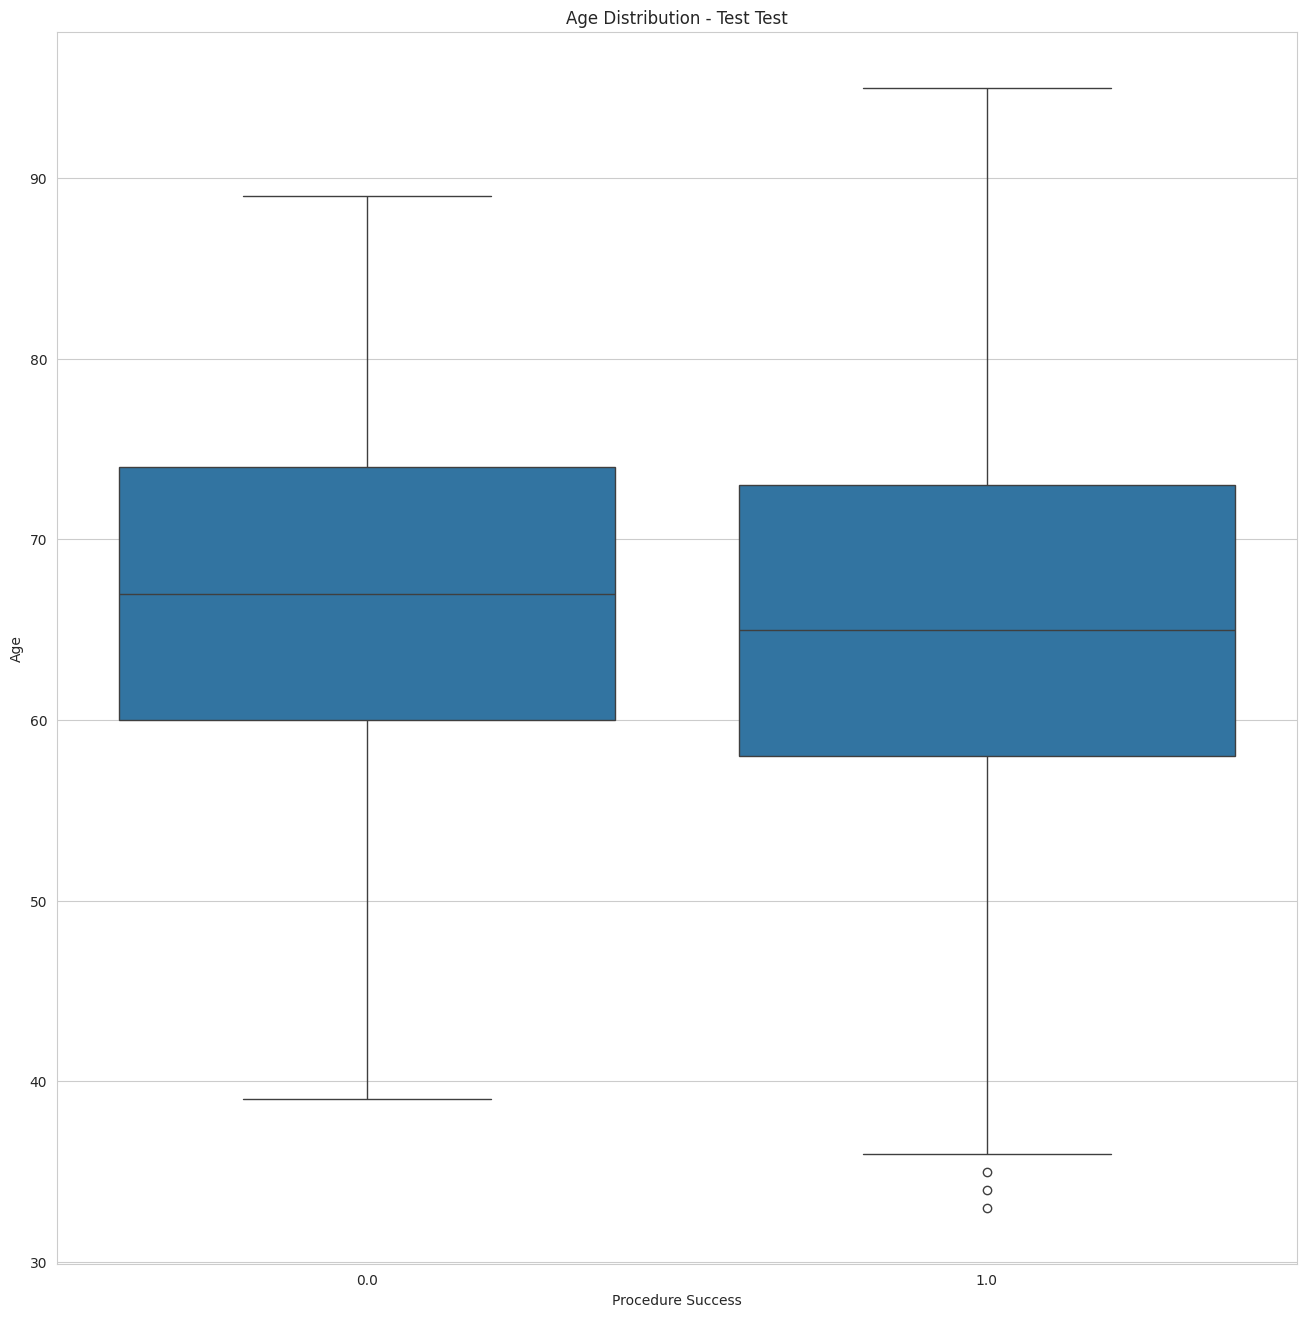

In [165]:
# Plot the age
sns.boxplot(x="procedure_success", y="age", data=df_test).set(title = "Age Distribution - Test Test", xlabel = "Procedure Success", ylabel = "Age")
plt.savefig('reports/figures/age_distribution_test.pdf', dpi=900)

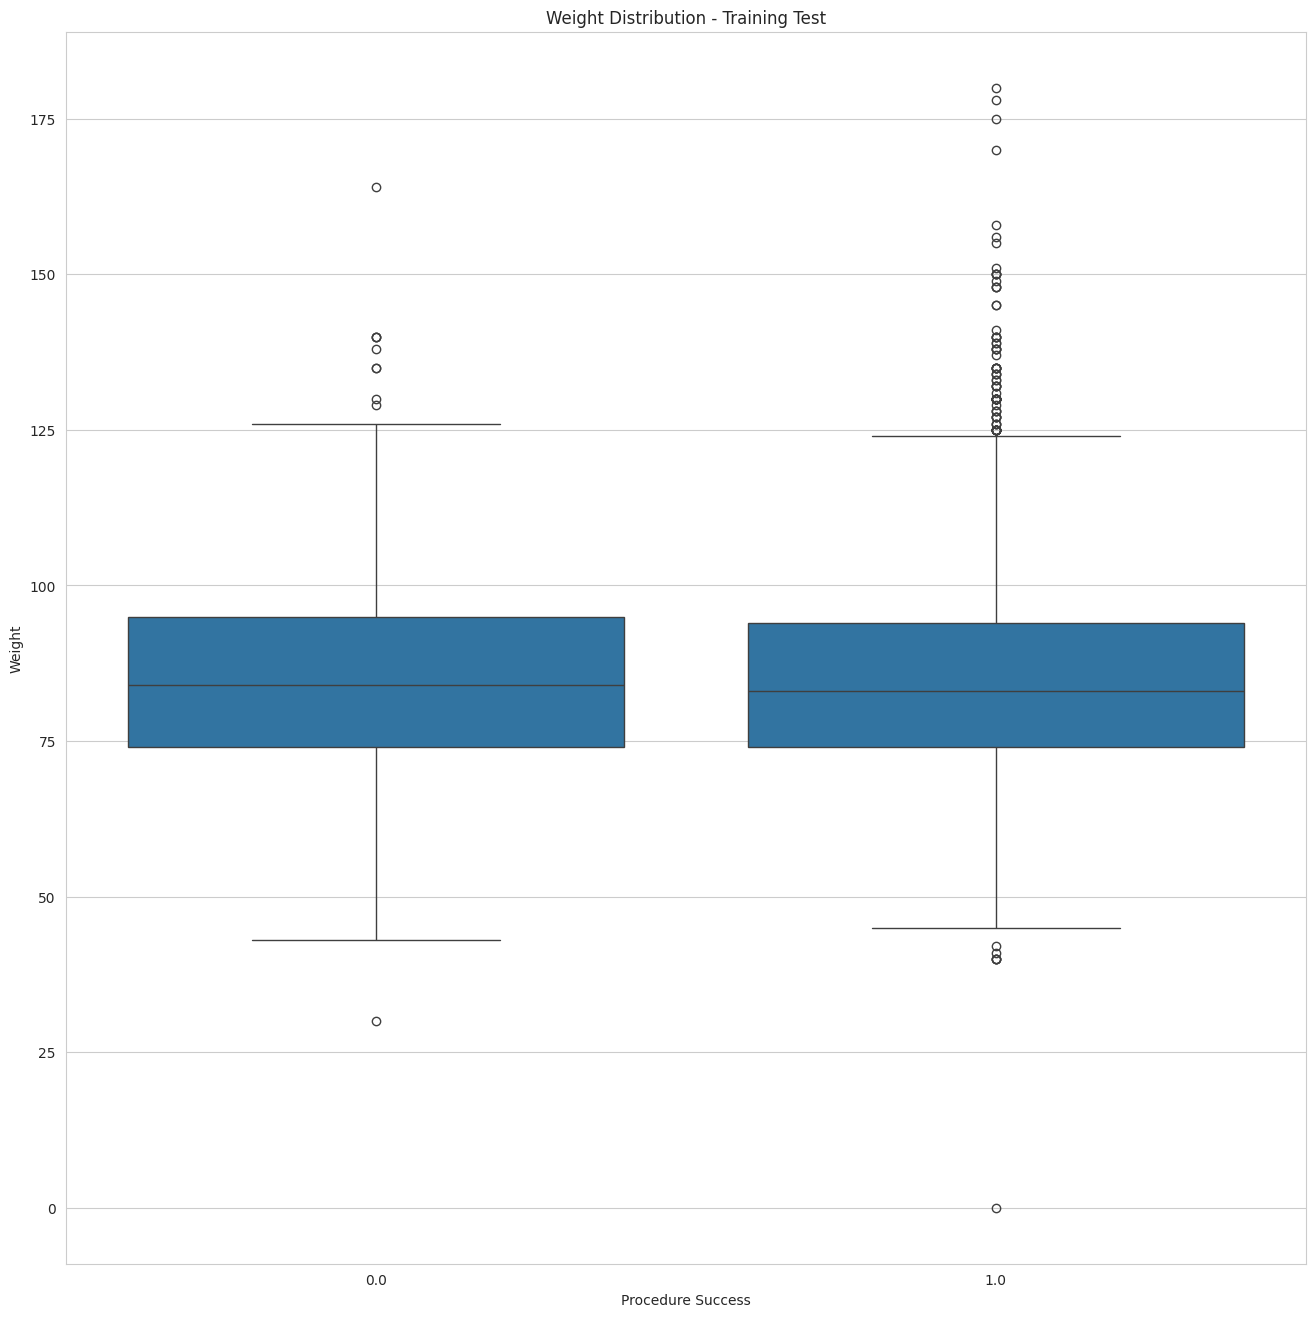

In [166]:
sns.boxplot(x="procedure_success", y="weight", data=df_train).set(title = "Weight Distribution - Training Test", xlabel = "Procedure Success", ylabel = "Weight")
plt.savefig('reports/figures/weight_distribution_training.pdf', dpi=900)

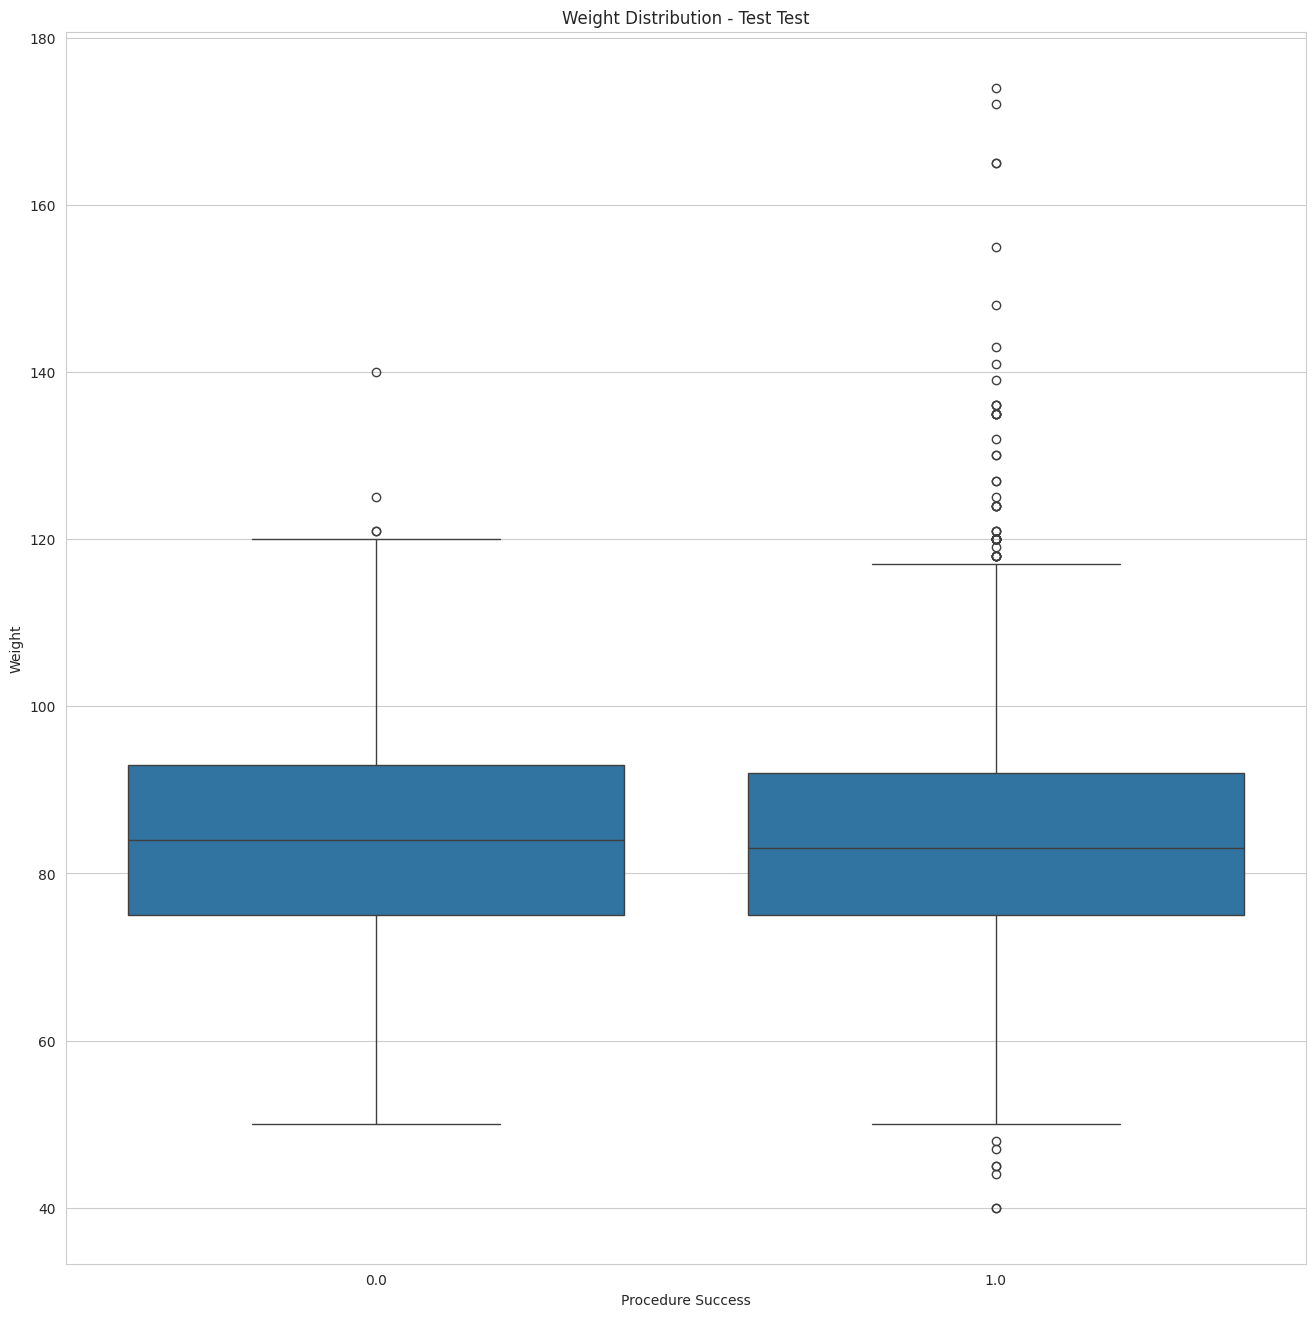

In [167]:
sns.boxplot(x="procedure_success", y="weight", data=df_test).set(title = "Weight Distribution - Test Test", xlabel = "Procedure Success", ylabel = "Weight")
plt.savefig('reports/figures/weight_distribution_test.pdf', dpi=900)

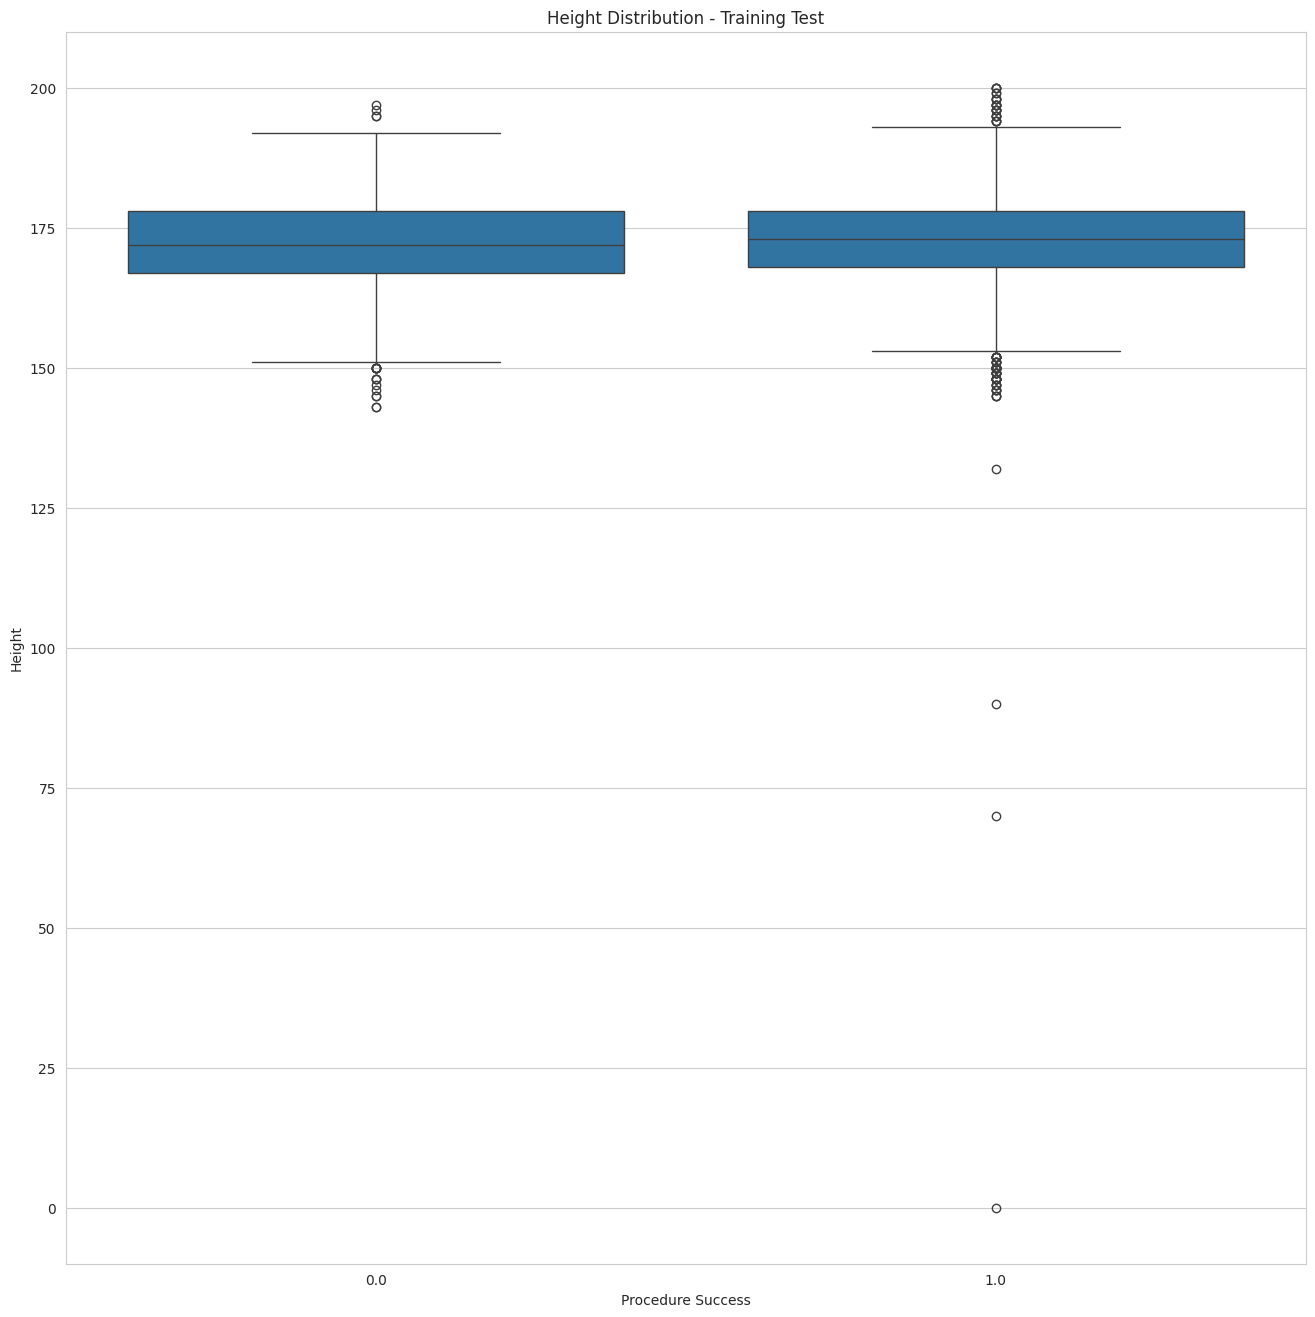

In [168]:
sns.boxplot(x="procedure_success", y="length", data=df_train).set(title = "Height Distribution - Training Test", xlabel = "Procedure Success", ylabel = "Height")
plt.savefig('reports/figures/height_distribution_training.pdf', dpi=900)

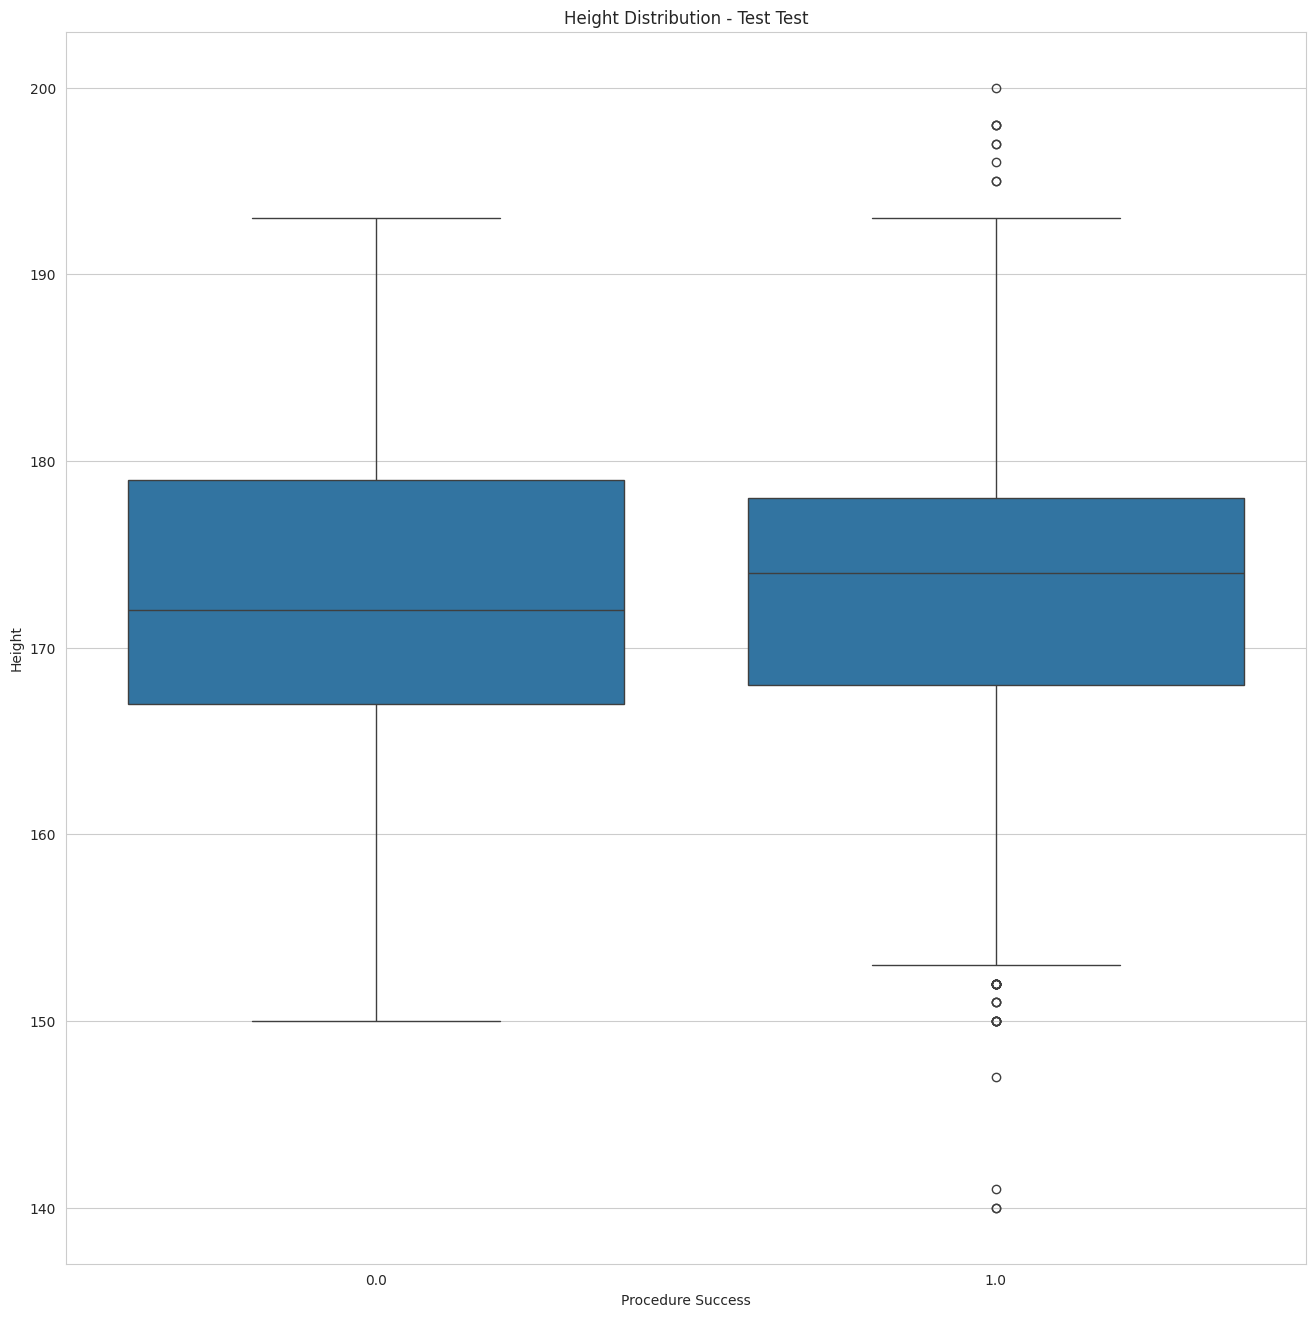

In [169]:
sns.boxplot(x="procedure_success", y="length", data=df_test).set(title = "Height Distribution - Test Test", xlabel = "Procedure Success", ylabel = "Height")
plt.savefig('reports/figures/height_distribution_test.pdf', dpi=900)

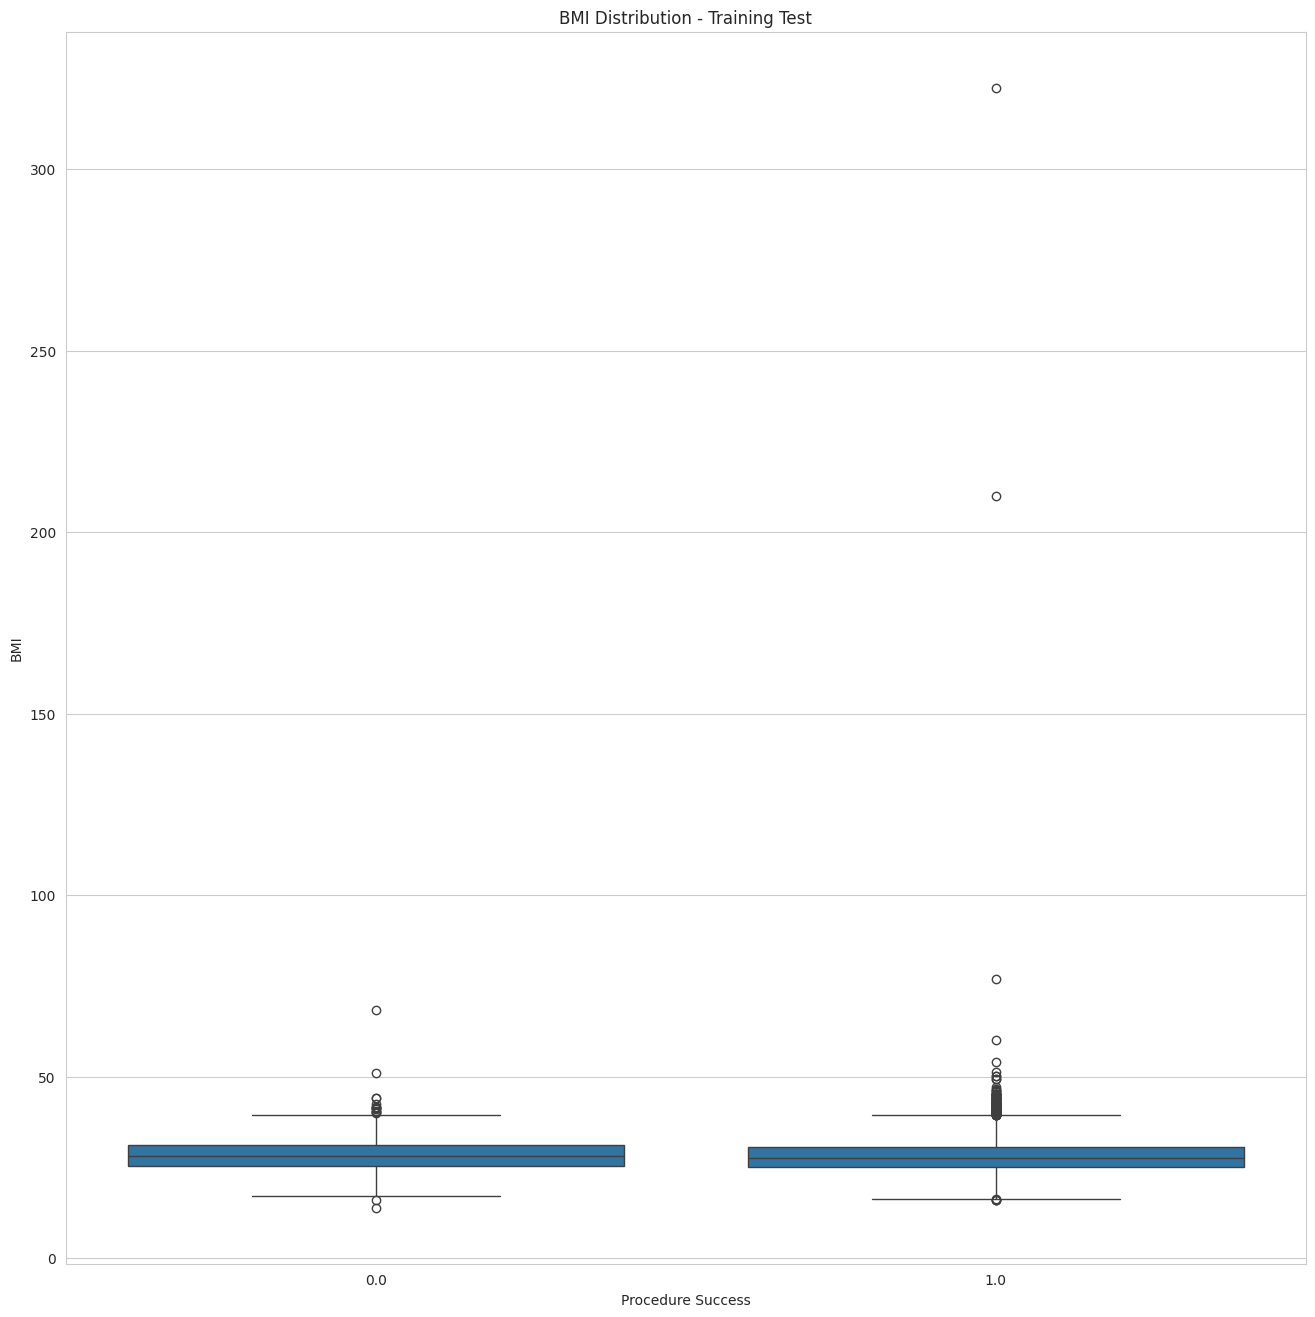

In [170]:
sns.boxplot(x="procedure_success", y="bmi", data=df_train).set(title = "BMI Distribution - Training Test", xlabel = "Procedure Success", ylabel = "BMI")
plt.savefig('reports/figures/bmi_distribution_training.pdf', dpi=900)

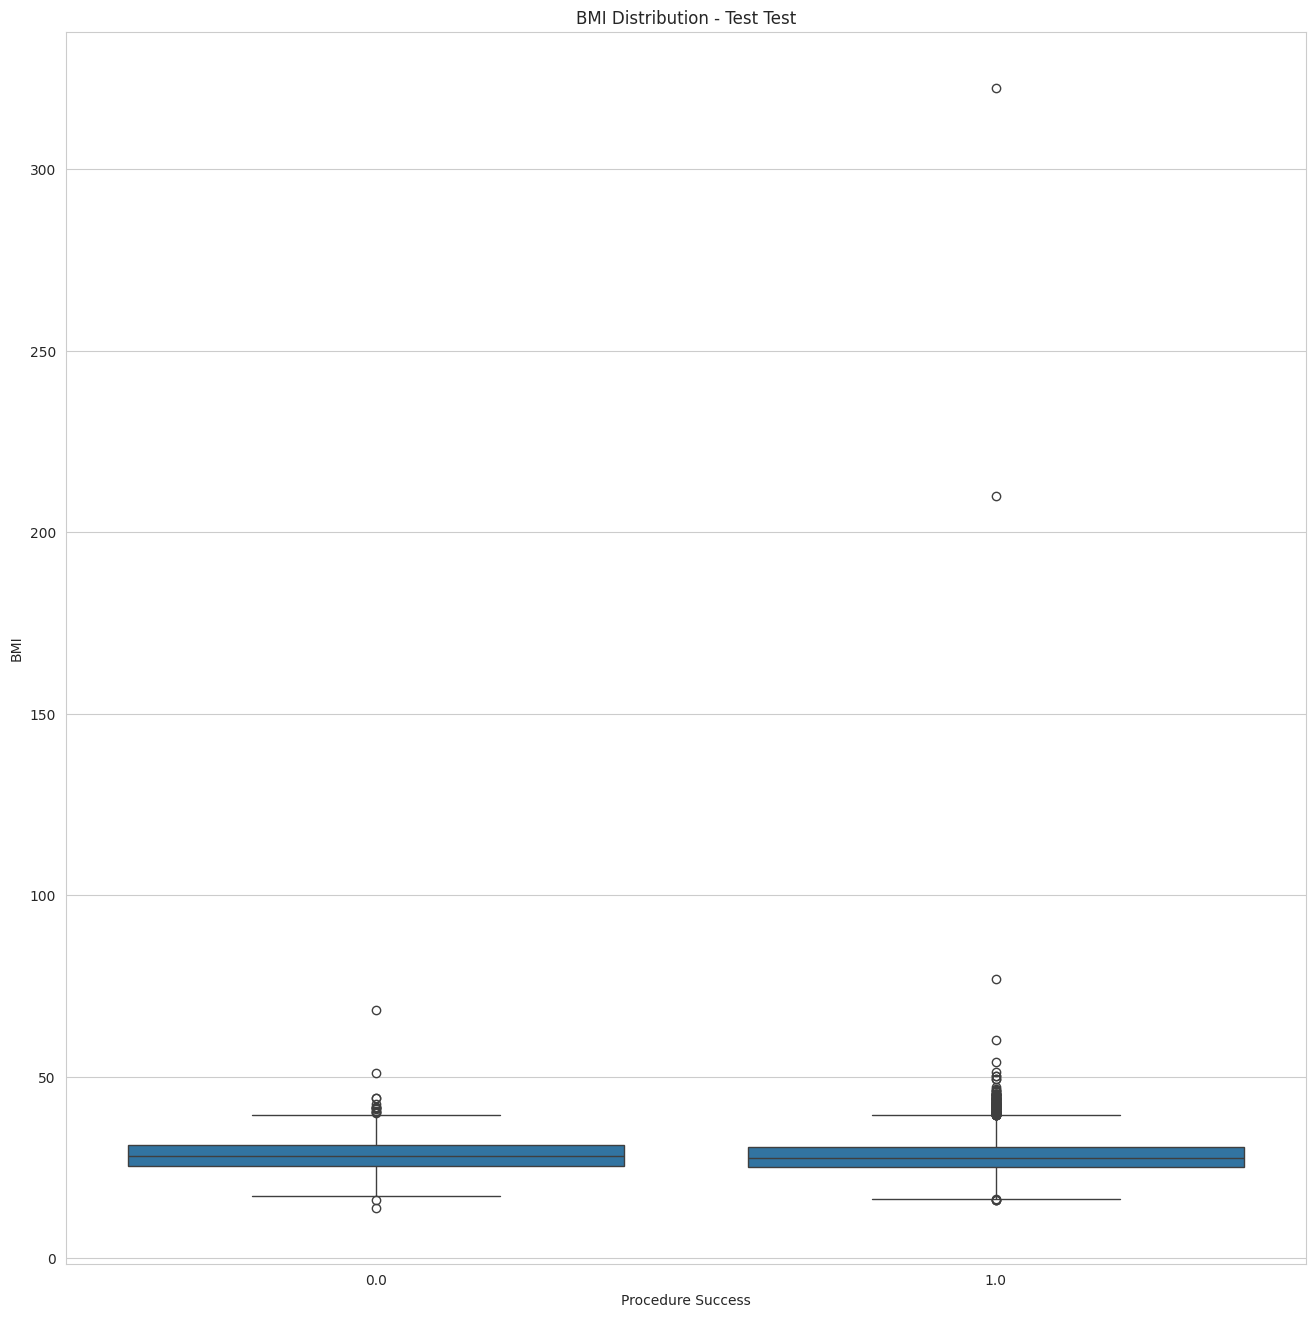

In [171]:
sns.boxplot(x="procedure_success", y="bmi", data=df_train).set(title = "BMI Distribution - Test Test", xlabel = "Procedure Success", ylabel = "BMI")
plt.savefig('reports/figures/bmi_distribution_test.pdf', dpi=900)